In [7]:
# Boilerplate
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
%matplotlib inline
from matplotlib.pyplot import *

# List physical devices
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [8]:
from importlib import reload

import backbone
import rpn

if 'data_utils' not in sys.modules:
    import data_utils
    import backbone
    import rpn
else:
    reload(data_utils)
    reload(backbone)
    reload(rpn)

In [9]:
# Data loading classes
full = data_utils.DataLoaderFull()
train_dataset = full.get_training(validation_split=0.2, batch_size=64, shuffle=True)
valid_dataset = full.get_validation(validation_split=0.2, batch_size=64, shuffle=False)

Found 23501 files belonging to 3 classes.
Using 18801 files for training.


2021-12-15 23:03:36.462807: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 23501 files belonging to 3 classes.
Using 4700 files for validation.


In [10]:
# Instantiate the backbone
roids = backbone.Backbone_InceptionResNetV2()
treadmills=rpn.RPNWrapper(roids)

(21, 38, 9)


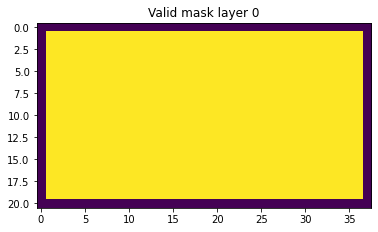

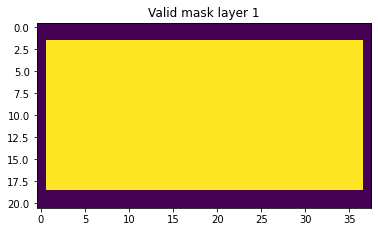

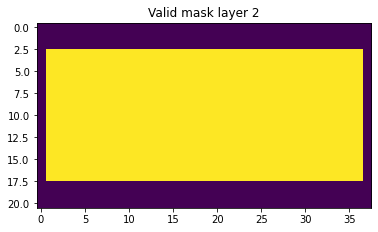

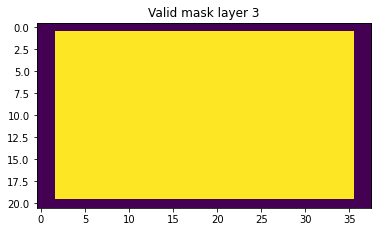

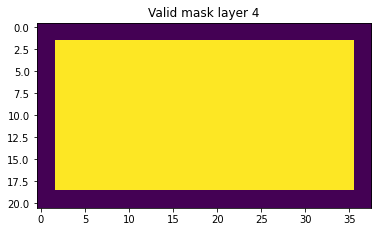

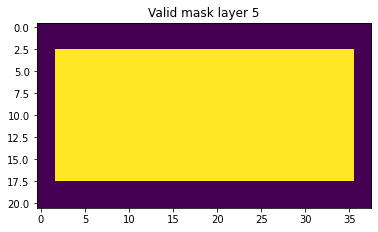

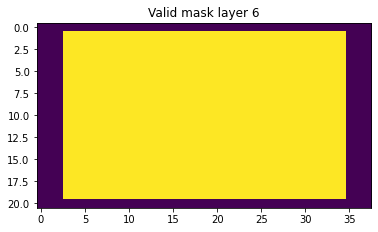

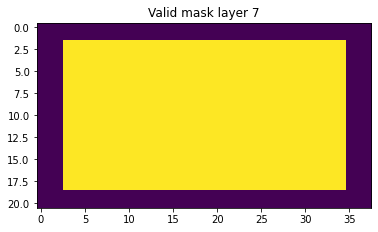

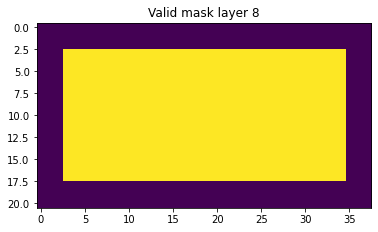

In [11]:
print(treadmills.valid_mask.shape)
    
for i in range(9):
    figure()
    imshow(treadmills.valid_mask[:,:,i], interpolation='nearest')
    title('Valid mask layer %d'%i)    

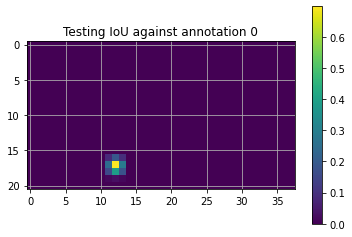

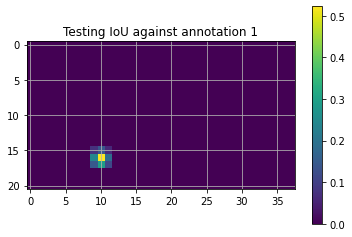

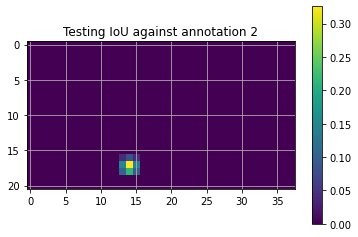

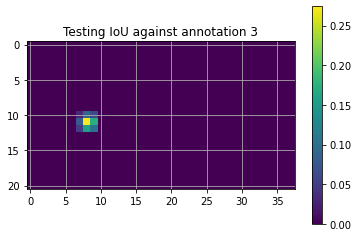

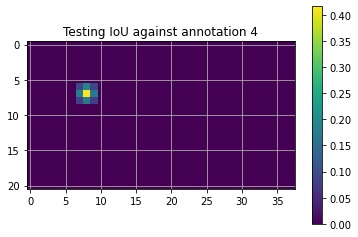

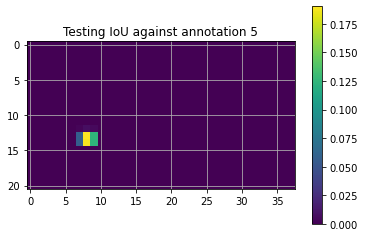

In [12]:
# Now let's check that the IoU calculation is doing something sane
annotations=[{'x': 406, 'y': 591, 'width': 57, 'height': 58}, 
             {'x': 334, 'y': 555, 'width': 54, 'height': 42}, 
             {'x': 471, 'y': 591, 'width': 36, 'height': 39}, 
             {'x': 276, 'y': 381, 'width': 38, 'height': 31}, 
             {'x': 269, 'y': 239, 'width': 50, 'height': 36}, 
             {'x': 275, 'y': 459, 'width': 30, 'height': 27}]   

IoUs = treadmills.ground_truth_IoU(annotations, treadmills.anchor_xx, treadmills.anchor_yy, 2, 2)

for i in range(len(annotations)):
    f=figure()
    imshow(IoUs[i])
    title('Testing IoU against annotation %d'%i)
    gca().grid(True)
    colorbar()

In [13]:
# Make one features tensor minibatch
for train_x, label_x in train_dataset:
    features = roids.extractor(train_x)
    label_decode = [full.decode_label(label) for label in label_x]
    break

In [40]:
import warnings

self = treadmills
self.rpn_minibatch = 256
self.IoU_neg_threshold = 0.1
self.IoU_pos_threshold = 0.7

#Number of tries to find a four valid RoIs
CUTOFF=100

# Method that will eventually belong to the RPNWrapper class
def training_step(features, label_decode):

    # Sanity checking
    assert features.shape[0] == len(label_decode)
    rois=[]
    
    # Now iterate over images in the minibatch
    for i, this_label in enumerate(label_decode):
        '''
        Fill the list of ROIs with both positive and negative examples
        
        Return (rpn_minibatch/images) samples (image number, xx, yy, hh, ww, {}) 
        corresponding to negative examples no matter what. This ensures that we 
        have enough examples to fill out the RPN minibatch
        
        For each ground truth positive in label_decode append
        a) The best IoU as a positive
        b) Any region proposal with IoU > self.IoU_threshold
        '''
        
        # Fill in negative examples by random sampling
        count=0
        for i in range(CUTOFF):
                
            if count >= self.rpn_minibatch / features.shape[0]:
                break
                
            # Pick one at random
            ixx = np.random.randint(self.anchor_xx.shape[1])
            iyy = np.random.randint(self.anchor_xx.shape[0])
            ik = np.random.randint(self.k)
        
            # Get coords for the guess
            xx = self.anchor_xx[iyy, ixx]
            yy = self.anchor_yy[iyy, ixx]
            hh = self.hh[ik]
            ww = self.ww[ik]
        
            # Check if this is a valid negative RoI
            if (self.valid_mask[iyy, iyy, ik] and 
                (len(this_label) == 0 or 
                all([IoU < self.IoU_neg_threshold for IoU in self.ground_truth_IoU(this_label, xx, yy, hh, ww)]))):
                rois.append([xx, yy, hh, ww, {}])
                count+=1
        
        # If there are positive examples return the example with the highest IoU per example
        # and any with IoU > threshold
    
    # Something has gone horribly wrong with collecting RoIs, so skip this training step
    if len(rois) < self.rpn_minibatch:
        warnings.warn('Something has gone wrong with collecting minibatch RoIs, skip training step.')
    
    print(rois)
    print(len(rois))
    
    
    # Finally, cut the list of RoIs down to something usable.
    # Do this by sorting on the existence of a ground truth
    # box + a small perturbation to randomly sample
    rois = sorted(rois, key = lambda roi:1.*(roi[-1] is not None) + 0.001 * np.random.random())
    rois = rois[:int(self.rpn_minibatch/2)] + rois[-1 * int(self.rpn_minibatch/2)]
    

training_step(features, label_decode)


[[8, 3, 6, 4, {}], [23, 17, 2, 6, {}], [4, 10, 2, 4, {}], [22, 7, 6, 2, {}], [5, 19, 2, 6, {}], [22, 5, 2, 2, {}], [20, 8, 6, 2, {}], [31, 15, 6, 2, {}], [4, 5, 2, 4, {}], [23, 11, 4, 4, {}], [22, 14, 4, 6, {}], [16, 12, 4, 2, {}], [0, 13, 4, 2, {}], [8, 3, 2, 6, {}], [30, 10, 4, 2, {}], [19, 9, 2, 6, {}], [37, 1, 2, 2, {}], [13, 10, 6, 2, {}], [27, 7, 6, 2, {}], [8, 17, 6, 2, {}], [13, 5, 6, 4, {}], [8, 10, 6, 4, {}], [18, 3, 6, 2, {}], [36, 14, 6, 2, {}], [23, 17, 6, 2, {}], [17, 12, 4, 6, {}], [37, 3, 2, 6, {}], [33, 17, 4, 6, {}], [29, 10, 6, 4, {}], [3, 18, 2, 6, {}], [13, 2, 4, 2, {}], [13, 3, 6, 6, {}], [9, 10, 2, 2, {}], [4, 17, 4, 2, {}], [15, 13, 6, 6, {}], [13, 11, 2, 2, {}], [27, 17, 6, 4, {}], [15, 8, 2, 2, {}], [12, 10, 2, 2, {}], [34, 3, 6, 2, {}], [13, 13, 6, 4, {}], [28, 5, 2, 4, {}], [14, 7, 4, 6, {}], [35, 6, 6, 6, {}], [26, 5, 4, 4, {}], [32, 17, 6, 2, {}], [6, 16, 4, 4, {}], [34, 14, 6, 2, {}], [9, 5, 4, 2, {}], [1, 12, 6, 6, {}], [24, 10, 4, 6, {}], [27, 10, 6, 2,

In [16]:
epochs=1
print(len(label_decode))
print(len([item for sub in label_decode for item in sub]))

64
42


In [ ]:
# Training step for the RPN
#
#    
#    pass


#for epoch in range(epochs):
#    for train_x, label_x in train_dataset:
#        print([full.decode_label(label) for label in label_x])
#        features = roids.extractor(train_x)
#        print(features.shape)
#        cls, bboxes = treadmills.rpn(features)
#        print(cls.shape)
#        print(bboxes.shape)
#        
#        # Now, for each anchor point and each k compute (the highest IoU with any of the annotations)
#        # Next sort boxes by this and pick out our training sample in this mini-batch
#        break